In [27]:
import pandas as pd
import numpy as np
data = pd.read_csv("basketball.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        82 non-null     object 
 1   pos           82 non-null     object 
 2   age           82 non-null     int64  
 3   bref_team_id  82 non-null     object 
 4   g             82 non-null     int64  
 5   gs            82 non-null     int64  
 6   mp            82 non-null     int64  
 7   fg            82 non-null     int64  
 8   fga           82 non-null     int64  
 9   fg.           82 non-null     float64
 10  x3p           82 non-null     int64  
 11  x3pa          82 non-null     int64  
 12  x3p.          82 non-null     float64
 13  x2p           82 non-null     int64  
 14  x2pa          82 non-null     int64  
 15  x2p.          82 non-null     float64
 16  efg.          82 non-null     float64
 17  ft            82 non-null     int64  
 18  fta           82 non-null     in

In [28]:
#tạo ra 5 điểm làm center ban đầu bằng cách lấy ngẫy nhiên từ data
num_cluster  = 5 
random_idx = np.random.choice(data.index, 5)
center_df = data.loc[random_idx,:].copy()
print(random_idx)
center_df

[45 57 49 79 31]


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
45,Gal Mekel,PG,25,DAL,31,1,292,30,86,0.349,...,63,4,1,31,31,73,2013-2014,2013,2.354839,2.032258
57,Luke Ridnour,PG,32,TOT,61,14,1141,126,327,0.385,...,176,32,8,66,92,306,2013-2014,2013,5.016393,2.666667
49,Steve Nash,PG,39,LAL,15,10,313,36,94,0.383,...,86,7,2,31,18,102,2013-2014,2013,6.800000,2.774194
79,Louis Williams,PG,27,ATL,60,7,1445,197,493,0.400,...,210,45,4,92,65,625,2013-2014,2013,10.416667,2.282609
31,Mike James,PG,38,CHI,11,0,77,5,21,0.238,...,17,2,0,5,11,11,2013-2014,2013,1.000000,3.400000


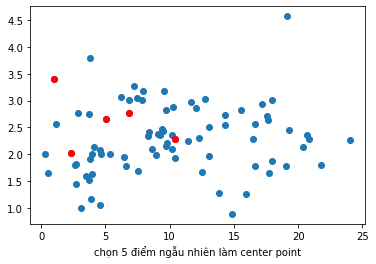

In [29]:
# vẽ biểu đồ sau khi chọn ngẫu nhiên 5 điểm làm trung tâm ban đầu, và chưa phân cụm data
import matplotlib.pyplot as plt
plt.scatter(data['ppg'],data['atr'])
plt.scatter(center_df['ppg'],center_df['atr'], color = 'red')
plt.xlabel('chọn 5 điểm ngẫu nhiên làm center point')
plt.show()

In [30]:
def create_dict_center(df_center):
    """
    hàm đưa 5 điểm center vào 1 dict riêng có values là tọa độ điểm (ppg-atr) 
    và key chính là tên cluster để dùng cho phần sau
    """
    count = 0
    dict_center = {}
    for idx, row in df_center.iterrows():
        coordinates =  [row['ppg'],row['atr']]
        dict_center[count]  = coordinates
        count += 1   
    return dict_center
center_dict = create_dict_center(center_df)    
center_dict

{0: [2.3548387096774195, 2.032258064516129],
 1: [5.016393442622951, 2.6666666666666665],
 2: [6.8, 2.774193548387097],
 3: [10.416666666666666, 2.282608695652174],
 4: [1.0, 3.4]}

In [31]:
def caculated_distance(center_point, player_point):
    
    """
    hàm tính khoảng cách euclid = (sum((q1-p1)^2 + ...+ (qn-pn)^2))^0.5
    """
    import math
    sum_dis = 0
    for i in range(len(center_point)):
        distance = center_point[i] - player_point[i]
        sum_dis += distance**2
    eculid_dis = math.sqrt(sum_dis)
    return eculid_dis

In [32]:
def excute_cluster(row):
    '''
    excute_cluster: hàm thực hiện phân cụm
    - Input: chỉ nhận 1 dòng của data,
    kết hợp với hàm apply bên ngoài hàm sẽ tính vs so sánh đc khoảng cách toàn bộ tập dữ liệu
    - Output: return label: 0,1,2,3,4
    - từ mỗi điểm quan sát tính 5 khoảng cách tới 5 center_point và so sánh ,
    => điểm quan sát sẽ thuộc cluster mà khoảng cách từ điểm đó đến center_point ngắn nhất.
    '''
    lowest_dis = None
    cluster_id = None
    play_pts = [row['ppg'], row['atr']]
    
    for keys, values in center_dict.items():
        distance = caculated_distance(values, play_pts)
        
        if lowest_dis == None:
            cluster_id = keys
            lowest_dis = distance
            
        elif distance < lowest_dis:
            lowest_dis = distance
            cluster_id = keys           
    return cluster_id
         
data['cluster'] = data.apply(lambda row: excute_cluster(row)  , axis = 1)

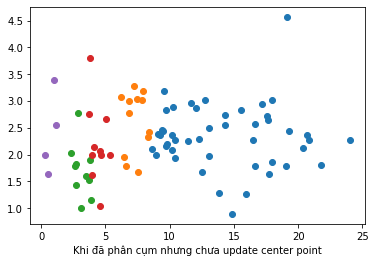

In [33]:
#visualize data khi đã phân cụm ( nhưng chưa update center point)
unique_cluster = data['cluster'].unique()
unique_cluster
for i in unique_cluster:
    df_temp = data[data['cluster']==i]
    plt.scatter(df_temp['ppg'],df_temp['atr'])
plt.xlabel('Khi đã phân cụm nhưng chưa update center point')    
plt.show()

In [34]:
def update_center_point(df):
    '''
    hàm update lại center point
    input: dict center 
    output: dict mới với values là các điểm có giá trị trung bình trong tập đã cluster
    '''
    dict_update = dict()
    for i in range(0, num_cluster):
        filter_df = df[df['cluster'] == i].copy()
        dict_update[i] = [np.mean(filter_df['ppg']), np.mean(filter_df['atr']) ]
                                  
    return dict_update

# Code Full

vẽ biểu đồ sau khi chọn ngẫu nhiên 5 điểm làm trung tâm ban đầu, và chưa phân cụm data: 


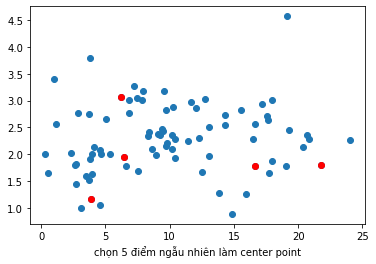

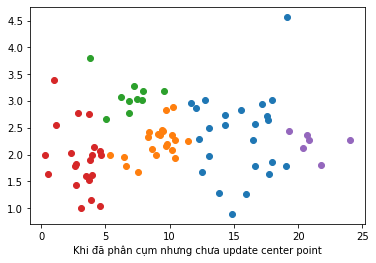

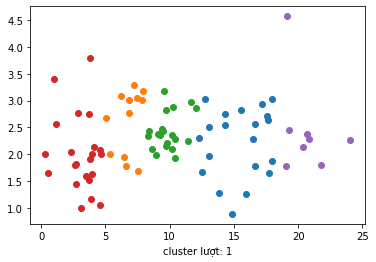

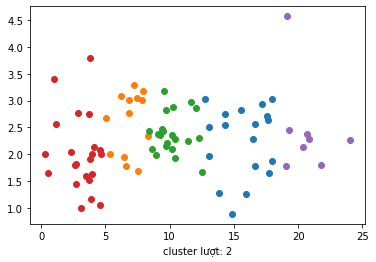

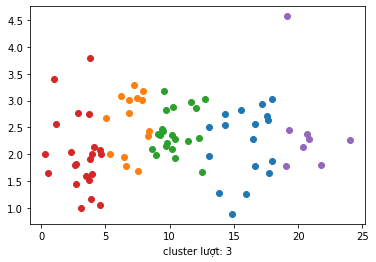

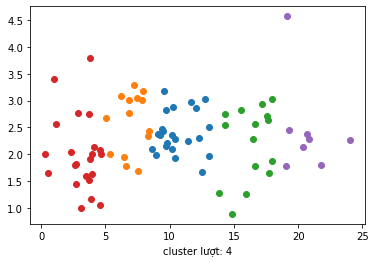

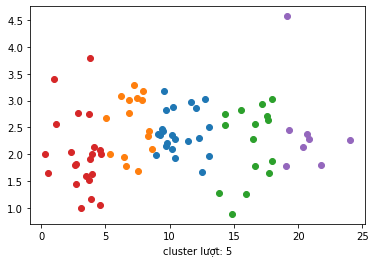

In [37]:
import pandas as pd
import numpy as np
data = pd.read_csv("basketball.csv")
num_cluster  = 5 
random_idx = np.random.choice(data.index, 5)
center_df = data.loc[random_idx,:].copy()

print('vẽ biểu đồ sau khi chọn ngẫu nhiên 5 điểm làm trung tâm ban đầu, và chưa phân cụm data: ')
import matplotlib.pyplot as plt
plt.scatter(data['ppg'],data['atr'])
plt.scatter(center_df['ppg'],center_df['atr'], color = 'red')
plt.xlabel('chọn 5 điểm ngẫu nhiên làm center point')
plt.show()

def create_dict_center(df_center):
    """
    hàm đưa 5 điểm center vào 1 dict riêng có values là tọa độ điểm (ppg-atr) 
    và key chính là tên cluster để dùng cho phần sau
    """
    count = 0
    dict_center = {}
    for idx, row in df_center.iterrows():
        coordinates =  [row['ppg'],row['atr']]
        dict_center[count]  = coordinates
        count += 1   
    return dict_center
  
def caculated_distance(center_point, player_point):
    
    """
    hàm tính khoảng cách euclid = (sum((q1-p1)^2 + ...+ (qn-pn)^2))^0.5
    """
    import math
    sum_dis = 0
    for i in range(len(center_point)):
        distance = center_point[i] - player_point[i]
        sum_dis += distance**2
    eculid_dis = math.sqrt(sum_dis)
    return eculid_dis

def excute_cluster(row):
    '''
    excute_cluster: hàm thực hiện phân cụm
    - Input: chỉ nhận 1 dòng của data,
    kết hợp với hàm apply bên ngoài hàm sẽ tính vs so sánh đc khoảng cách toàn bộ tập dữ liệu
    - Output: return label: 0,1,2,3,4
    - từ mỗi điểm quan sát tính 5 khoảng cách tới 5 center_point và so sánh ,
    => điểm quan sát sẽ thuộc cluster mà khoảng cách từ điểm đó đến center_point ngắn nhất.
    '''
    lowest_dis = None
    cluster_id = None
    play_pts = [row['ppg'], row['atr']]
    
    for keys, values in center_dict.items():
        distance = caculated_distance(values, play_pts)
        
        if lowest_dis == None:
            cluster_id = keys
            lowest_dis = distance
            
        elif distance < lowest_dis:
            lowest_dis = distance
            cluster_id = keys           
    return cluster_id
    
def update_center_point(df):
    '''
    hàm update lại center point
    input: dict center 
    output: dict mới với values là các điểm có giá trị trung bình trong tập đã cluster
    '''
    dict_update = dict()
    for i in range(0, num_cluster):
        filter_df = df[df['cluster'] == i].copy()
        dict_update[i] = [np.mean(filter_df['ppg']), np.mean(filter_df['atr']) ]
                                  
    return dict_update


center_dict = create_dict_center(center_df)  
data['cluster'] = data.apply(lambda row: excute_cluster(row)  , axis = 1)
#visualize data khi đã phân cụm ( nhưng chưa update center point)
unique_cluster = data['cluster'].unique()
unique_cluster
for i in unique_cluster:
    df_temp = data[data['cluster']==i]
    plt.scatter(df_temp['ppg'],df_temp['atr'])
plt.xlabel('Khi đã phân cụm nhưng chưa update center point')    
plt.show()

for i in range(5):
    center_dict = update_center_point(data)
    data['cluster'] = data.apply(lambda row: excute_cluster(row)  , axis = 1)
    unique_cluster = data['cluster'].unique()
    for k in unique_cluster:
        df_temp = data[data['cluster']==k]
        plt.scatter(df_temp['ppg'],df_temp['atr'])
    plt.xlabel(f'cluster lượt: {i+1}',)    
    plt.show()